### Import the necessary libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso #pip install eif==1.0.2  version 2.0.2 has a problem
import seaborn as sb
sb.set_style(style='whitegrid')
sb.set_color_codes()
import scipy.ndimage 
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import pandas as pd

###  Find the depth a given data point reaches in an IF tree

In [2]:
 def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)
        
def getVals(forest,x, sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for t in forest.Trees:
        r.append(getDepth(x,t.root,1))
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

### Load Water Humidity Data

In [3]:
df_turbidity = pd.read_csv("Data_Raw_Water.csv")
df_turbidity.head()

,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


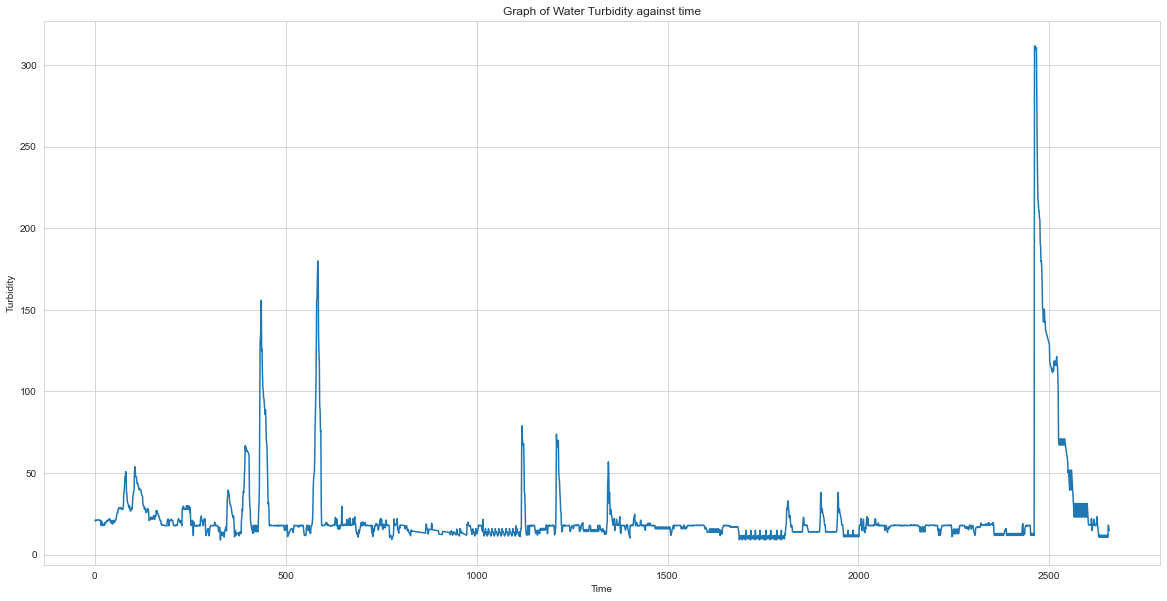

In [4]:
f1 = plt.figure(figsize=(20,10))
df_turbidity['turbidity'].plot()
plt.xlabel("Time")
plt.ylabel("Turbidity")
plt.title('Graph of Water Turbidity against time')
plt.show()

### Change timestamp to epoch.

In [5]:
epoch = pd.to_datetime(df_turbidity['time']).values.astype(np.int64)
df_turbidity['time'] = epoch

In [6]:
# Convert dataframe to array.
X = np.array(df_turbidity)

In [7]:
# Set values of axis x for plotting.
x = np.array(df_turbidity['time'])

In [8]:
# Set values of axis y for plotting.
y = np.array(df_turbidity['turbidity'])

In [9]:
%%time
#ExtensionLevel=0 is the same as regular Isolation Forest
F0 = iso.iForest(X , ntrees=100, sample_size=128, ExtensionLevel=0) # changed ntrees from 100 to 50, and sample_size from 256 to 64 

Wall time: 710 ms


In [10]:
%%time
# F1 is the Extended Isolation Forest with extension 1, which is the fully extended case.
F1 = iso.iForest(X , ntrees=100, sample_size=128, ExtensionLevel=1) # changed ntrees from 100 to 50, and sample_size from 256 to 64 


Wall time: 842 ms


In [11]:
%%time
# Function compute_paths returns that anomaly score. It computes the depth each points
# reaches in each trained tree, and converts the ensemble aggregate to an anomaly score.
# Score the training data itself to see the distribution of
# the anomaly scores each point receives.
S0 = F0.compute_paths(X_in=X)

Wall time: 17.9 s


In [12]:
#The following code is used to get a meaningful threshold to distinguish anomalies and normal data
anomalies0 = S0[S0 > 0.55]
anomalies0.size

279

In [13]:
%%time
S1 = F1.compute_paths(X_in=X) 

Wall time: 17.6 s


In [14]:
#The following code is used to get a meaningful threshold to distinguish anomalies and normal data
anomalies1 = S1[S1 > 0.56]
anomalies1.size

365

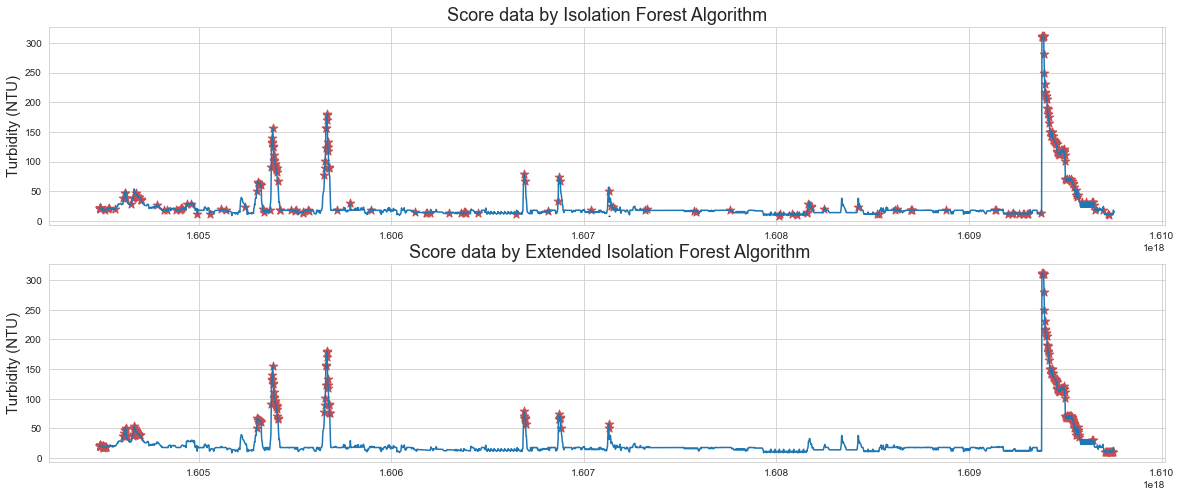

In [31]:
# Plot the points and highlight 30 points with highest and 30 points with lowest anomaly
# scores. The two plots provide a comparison between the two algorithms.

ss0=np.argsort(S0)
ss1=np.argsort(S1)
f = plt.figure(figsize=(20,8))   # changed from (12,6) to (20,6)
plt.subplot(2,1,1)
plt.plot(x,y)
plt.scatter(x[ss0[-240:]],y[ss0[-240:]],s=80,marker="*",c='r')
#plt.scatter(x[ss0[:30]],y[ss0[:30]],s=55,c='r')
plt.title('Score data by Isolation Forest Algorithm',size=18)
plt.ylabel('Turbidity (NTU)',size=15)

plt.subplot(2,1,2)
plt.plot(x,y)
plt.scatter(x[ss1[-240:]],y[ss1[-240:]],s=80,marker="*",c='r')
#plt.scatter(x[ss1[:80]],y[ss1[:80]],s=55,c='r')
plt.title(' .\n \n Score data by Extended Isolation Forest Algorithm',size=18)
plt.ylabel('Turbidity (NTU)',size=15)
plt.show()


In [30]:
ss0

array([1371, 1463, 1403, ...,  584, 2463,  583], dtype=int64)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [17]:
turb_train = np.array(df_turbidity)

In [18]:
%%time
# fit the model
clf = IsolationForest()
clf.fit(turb_train)
pred = clf.predict(turb_train)

Wall time: 469 ms


In [19]:
df_turbidity['anomaly']=pred

In [27]:
outliers = df_turbidity.loc[df_turbidity['anomaly']==-0.5]
outlier_index = list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points
#classified -1 are anomalous
print(df_turbidity['anomaly'].value_counts())

 1    2250
-1     408
Name: anomaly, dtype: int64


In [21]:
anomalies_only = outliers[['time','turbidity', 'anomaly']]
anomalies_only

,time,turbidity,anomaly
0,1604487631822439000,21.063435,-1
1,1604487682124333000,20.868153,-1
2,1604487711663062000,20.584553,-1
3,1604487749373718000,21.185328,-1
4,1604487825517010000,21.063435,-1
...,...,...,...
2649,1609739536741753000,11.856159,-1
2650,1609741352783847000,10.611506,-1
2655,1609750433104009000,17.734662,-1
2656,1609752249578901000,15.094176,-1
